# Fun with barrier method

Below you can find a Python code of the barrier method (as introduced in the lecture) for a linear program in the form

$$\begin{array}{ll@{\quad}l}
	\text{minimize}  & cx &\\
	\text{subject to}& Ax   \le b. \\
	\end{array}$$ 
    
Begin from understanding what's going on.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [14]:
def backtracking_line_search(f, in_domain_of_f, df, x, dx, alpha=0.1, beta=0.8):
    """
    Perform backtracking line search.
    
    Args:
        f: The objective function.
        df: The gradient of the objective function.
        x: The current point.
        dx: The current direction.
        alpha: The proportionality constant.
        beta: The shrinkage factor.
    """
    t = 1
    while not in_domain_of_f(x + t*dx):
        t *= beta
    while f(x + t * dx) > f(x) + alpha * t * np.dot(df(x), dx):
        t *= beta

    return t

In [15]:
def newtons_method(f, in_domain_of_f, df, ddf, x, eps=1e-4):
    """
    Perform Newton's method to minimize a function.
    
    Args:
        f: The objective function.
        df: The gradient of the objective function.
        ddf: The Hessian of the objective function.
        x: The initial point.
        eps: The tolerance for stopping criterion.
    """
    steps = [x.copy()]
    while True: 
        dx = -np.linalg.solve(ddf(x), df(x))
        lambda_sq = -df(x) @ dx
        if lambda_sq/2 <= eps:
            break
        t = backtracking_line_search(f, in_domain_of_f, df, x, dx)
        x += t * dx
        steps.append(x.copy())

    return x, steps

In [16]:
def barrier_method(c, A, b, x_0, eps=1e-4, mu=20, t0=1, phase_one=False):
    """
    Perform barrier method to solve a linear programming problem.
    
    minimize c^Tx
    subject to Ax <= b
    
    Args:
        c: An ndarray of shape (n, ). The coefficient of the objective function.
        A: An ndarray of shape (m, n). The coefficient matrix of the inequality constraints.
        b: An ndarray of shape (m, ). The RHS of the inequality constraints.
        x_0: An ndarray of shape (n, ). The initial strictly feasible solution.
        eps: The tolerance for stopping criterion.
        mu: The parameter for updating t.
        t0: The initial t.
    """
    m, n = A.shape
    x = x_0.copy()

    steps = [x.copy()]
    newt_steps = []
    t = t0
    
    while (phase_one and x[-1]>0) or (not phase_one and m / t >= eps):
        # centering step
        # define new objective function, its derivative and second derivative
        f = lambda x: t * c @ x - np.sum(np.log(b - A @ x))
        in_domain_of_f = lambda x: all(b - A @ x > 0)
        df = lambda x: t * c + np.sum(A.T / (b - A @ x), axis=1)
        ddf = lambda x: (A.T / (b - A @ x)**2) @ A

        # perform Newton's method
        x, newt_steps_here = newtons_method(f, in_domain_of_f, df, ddf, x)
        steps.append(x.copy())
        newt_steps.append(newt_steps_here)

        # update t
        t *= mu

    return x, steps, newt_steps


Below is a function for drawing iterations for 2d problems.

In [17]:
def plot_iterations(vertices, steps1, steps2):
    xs, ys = zip(*(vertices + [vertices[0]])) #create lists of x and y values

    plt.fill(xs,ys,facecolor='lightblue', edgecolor='tab:blue', linewidth=1)
    if len(steps1) > 0:
        plt.plot(steps1[0][0], steps1[0][1], 'o', color=(1,0.2,0.2))
    for x in steps1:
        plt.plot(x[0], x[1], '.', color=(0.8,0.2,0.2))
    if len(steps2) > 0:
        plt.plot(steps2[0][0], steps2[0][1], 'o', color=(0.2,1,0.2))
    for x in steps2:
        plt.plot(x[0], x[1], '.', color=(0.2,0.5,0.2))

Now we create a 2d problem, by giving vertices of a polygon (so that it is easier to play with it)

In [18]:
vertices = [(0,0), (3,0), (3.2, 0.2), (2/3,2+2/3),  (-6, 2/3)]
vertices = vertices[::-1]
edges = zip(vertices, vertices[1:] + [vertices[0]])

m = len(vertices)
n = 2

A = np.zeros((m, n))
b = np.zeros(m)
i = 0

for (x1, y1), (x2, y2) in edges:
    dx = x2 - x1
    dy = y2 - y1
    
    A[i] = [-dy, dx]
    b[i] = dx*y1 - dy*x1
    i += 1
    
c = np.array([0.7, 1])   
c = np.array([0, -1])   
x_0 = np.array([1.9, 0.1])
    
A, b, c

(array([[-2.        ,  6.66666667],
        [ 2.46666667,  2.53333333],
        [ 0.2       , -0.2       ],
        [ 0.        , -3.        ],
        [-0.66666667, -6.        ]]),
 array([16.44444444,  8.4       ,  0.6       ,  0.        ,  0.        ]),
 array([ 0, -1]))

## Playing with a 2d instance

Now we solve the 2d problem. 
1. Explain what you see. Why the green dots (outer iterations) are first so dense, then a bit sprarser, and finally again dense?
2. Play with different objective functions, starting points and parameters ```mu```, ```t0```.

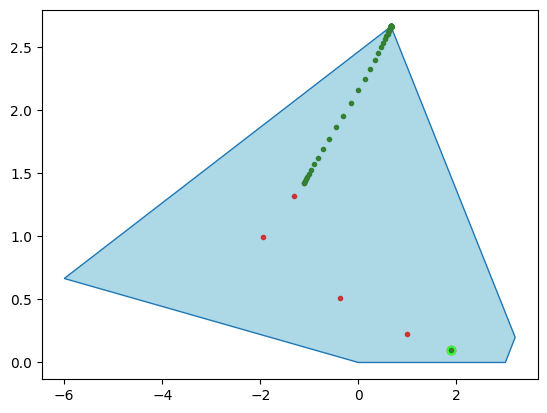

In [19]:
# Solve problem
x_opt, steps, newt_steps = barrier_method(c, A, b, x_0, 1e-5, 1.3, 0.1)
plot_iterations(vertices, newt_steps[0], steps)

## Large dimension intance

Below we create a random LP. 

1. Solve it using our barrier solver and compare the result to that found by gurobipy/cvxpy.
2. Play with parameters ```mu```, ```t0``` to get best results
3. (optional) Visualize the number of iterations of Newton method in subsequent outer iterations of barrier method. What do you observe? How these numbers behave when you change ```mu```?

In [ ]:
m = 1000
n = 200

v = np.random.rand(n)*10 
A = np.random.rand(m//2,n) - 0.5
A = np.append(A, -A, axis=0)
b = np.maximum(A@v,-A@v) + np.random.rand(m) + 0.1
c = np.random.rand(n) - 0.5

## Adding Phase I

So far, we assumed that one magically gets a strictly feasible solution. Extend the code adding Phase I which finds the initial strictly feasible solution. 
1. Run the new code on the small instance and draw the iterations of both phases using ```plot_iterations```. 
2. Run the new code on the large instance
3. (optional) Visualize the number of iterations of Newton method on the large instance in subsequent outer iterations of barrier method. What do you observe? How these numbers behave when you change mu?

In [20]:
def two_phase_get_strictly_feasible(A, b, c, mu = 1.3, t0 = 0.1):
    # ...your code goes here
    
    # you should return lists of points from phase 1 and phase 2 (the last point of the second list is the solution)
    return steps1, steps2 